# **Data preprocessing**

This notebook is for preprocessing raw data exported from the Shimmer EXG unit and GSR+ unit. We renamed columns, checked data quality, and applied filters.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sys import path
path.append('../../heartview/')
from heartview.pipeline import ECG
from scipy.fft import fft, fftfreq

## **Load and check data**

In [3]:
data_dir = '../data/raw/'
output_dir = '../data/preprocessed/'
fs_ecg = 1024
fs_eda = 4
condition = 'positive'
person = 'YW'
session = 'NY'

# Read data
if session == 'NY' or session == 'NN':
    df_ecg = pd.read_csv(data_dir + f'{session}_{condition}_Session1_ECG_{person}_Calibrated_SD.csv', skiprows=1)
    df_eda = pd.read_csv(data_dir + f'{session}_{condition}_Session1_EDA_{person}_Calibrated_SD.csv', skiprows=1)
elif session == 'MG' or session == 'VM':
    df_ecg = pd.read_csv(data_dir + f'{session}_Session1_ECG_{person}_Calibrated_SD.csv', skiprows=1)
    df_eda = pd.read_csv(data_dir + f'{session}_Session1_EDA_{person}_Calibrated_SD.csv', skiprows=1)

# Set output file names
if session == 'NY' or session == 'NN':
    output_filename_ecg = f'{session}_{condition}_ECG_{person}_preprocessed.csv'
    output_filename_eda = f'{session}_{condition}_EDA_{person}_preprocessed.csv'
elif session == 'MG' or session == 'VM':
    output_filename_ecg = f'{session}_ECG_{person}_preprocessed.csv'
    output_filename_eda = f'{session}_EDA_{person}_preprocessed.csv'

/var/folders/1x/tmzcjdgn7wqdrcsl41btp5vh0000gn/T/ipykernel_63531/774763534.py:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ecg = pd.read_csv(data_dir + f'{session}_{condition}_Session1_ECG_{person}_Calibrated_SD.csv', skiprows=1)


In [4]:
df_ecg

,ECG_YW_Timestamp_Unix_CAL,ECG_YW_Accel_LN_X_CAL,ECG_YW_Accel_LN_Y_CAL,ECG_YW_Accel_LN_Z_CAL,ECG_YW_ECG_EMG_Status1_CAL,ECG_YW_ECG_EMG_Status2_CAL,ECG_YW_ECG_LA-RA_24BIT_CAL,ECG_YW_ECG_LL-LA_24BIT_CAL,ECG_YW_ECG_LL-RA_24BIT_CAL,ECG_YW_ECG_Vx-RL_24BIT_CAL,ECG_YW_Pressure_BMP180_CAL,ECG_YW_Temperature_BMP180_CAL,Unnamed: 12
0,ms,m/(s^2),m/(s^2),m/(s^2),no_units,no_units,mV,mV,mV,mV,kPa,Degrees Celsius,NaN
1,1.7320491261481934E12,-0.18072289156626506,-2.4457831325301207,9.373493975903616,128.0,128.0,1.7193796300148525,-606.7194517516436,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552,NaN
2,1.7320491261520996E12,-0.16867469879518074,-2.4819277108433737,9.373493975903616,128.0,128.0,1.7356069964894054,-606.7356791181182,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552,NaN
3,1.7320491261530762E12,-0.16867469879518074,-2.4578313253012047,9.373493975903616,128.0,128.0,1.7345251720577686,-606.7345972936865,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552,NaN
4,1.7320491261540527E12,-0.18072289156626506,-2.4457831325301207,9.3855421686747,128.0,128.0,1.7334433476261315,-606.7335154692549,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
622323,1732049734941.162109,0.506024,-0.253012,10.301205,128.0,128.0,6.909613,-611.909685,-605.000072,-605.000072,100.872486,30.559142,NaN
622324,1732049734942.138916,0.614458,-0.192771,10.373494,128.0,128.0,6.904925,-611.904997,-605.000072,-605.000072,100.872486,30.559142,NaN
622325,1732049734943.115234,0.60241,-0.216867,10.481928,128.0,128.0,6.906007,-611.906079,-605.000072,-605.000072,100.872486,30.559142,NaN
622326,1732049734944.091797,0.650602,-0.240964,10.481928,128.0,128.0,6.906007,-611.906079,-605.000072,-605.000072,100.872486,30.559142,NaN


In [5]:
# Remove unnecessary columns
unnamed_cols_ecg = [col for col in df_ecg.columns if col.startswith('Unnamed')]
unnamed_cols_eda = [col for col in df_eda.columns if col.startswith('Unnamed')]
print(unnamed_cols_ecg, unnamed_cols_eda)

['Unnamed: 12'] ['Unnamed: 10']


In [6]:
# Rename columns
df_ecg = df_ecg.iloc[1:, :].drop(columns=unnamed_cols_ecg).reset_index(drop=True).rename(columns={
        f'ECG_{person}_Timestamp_Unix_CAL': 'timestamp', 
        f'ECG_{person}_Accel_LN_X_CAL': 'acc_x',
        f'ECG_{person}_Accel_LN_Y_CAL': 'acc_y',
        f'ECG_{person}_Accel_LN_Z_CAL': 'acc_z',
        f'ECG_{person}_ECG_EMG_Status1_CAL': 'ecg_emg_status1',
        f'ECG_{person}_ECG_EMG_Status2_CAL': 'ecg_emg_status2',
        f'ECG_{person}_ECG_LA-RA_24BIT_CAL': 'ecg_la_ra', 
        f'ECG_{person}_ECG_LL-LA_24BIT_CAL': 'ecg_ll_la', 
        f'ECG_{person}_ECG_LL-RA_24BIT_CAL': 'ecg_ll_ra',
        f'ECG_{person}_ECG_Vx-RL_24BIT_CAL': 'ecg_vx_rl',
        f'ECG_{person}_Gyro_X_CAL': 'gyro_x',
        f'ECG_{person}_Gyro_Y_CAL': 'gyro_y',
        f'ECG_{person}_Gyro_Z_CAL': 'gyro_z',
        f'ECG_{person}_Pressure_BMP180_CAL': 'pressure',
        f'ECG_{person}_Temperature_BMP180_CAL': 'temperature'
    })
df_ecg

,timestamp,acc_x,acc_y,acc_z,ecg_emg_status1,ecg_emg_status2,ecg_la_ra,ecg_ll_la,ecg_ll_ra,ecg_vx_rl,pressure,temperature
0,1.7320491261481934E12,-0.18072289156626506,-2.4457831325301207,9.373493975903616,128.0,128.0,1.7193796300148525,-606.7194517516436,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552
1,1.7320491261520996E12,-0.16867469879518074,-2.4819277108433737,9.373493975903616,128.0,128.0,1.7356069964894054,-606.7356791181182,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552
2,1.7320491261530762E12,-0.16867469879518074,-2.4578313253012047,9.373493975903616,128.0,128.0,1.7345251720577686,-606.7345972936865,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552
3,1.7320491261540527E12,-0.18072289156626506,-2.4457831325301207,9.3855421686747,128.0,128.0,1.7334433476261315,-606.7335154692549,-605.0000721216288,-605.0000721216288,100.85049739448164,29.025256436125552
4,1.7320491261550293E12,-0.18072289156626506,-2.4457831325301207,9.361445783132531,128.0,128.0,1.7338039557700107,-606.7338760773988,-605.0000721216288,-605.0000721216288,100.85195433843121,29.025256436125552
...,...,...,...,...,...,...,...,...,...,...,...,...
622322,1732049734941.162109,0.506024,-0.253012,10.301205,128.0,128.0,6.909613,-611.909685,-605.000072,-605.000072,100.872486,30.559142
622323,1732049734942.138916,0.614458,-0.192771,10.373494,128.0,128.0,6.904925,-611.904997,-605.000072,-605.000072,100.872486,30.559142
622324,1732049734943.115234,0.60241,-0.216867,10.481928,128.0,128.0,6.906007,-611.906079,-605.000072,-605.000072,100.872486,30.559142
622325,1732049734944.091797,0.650602,-0.240964,10.481928,128.0,128.0,6.906007,-611.906079,-605.000072,-605.000072,100.872486,30.559142


In [7]:
# Rename columns
df_eda = df_eda.iloc[1:, :].drop(columns=unnamed_cols_eda).reset_index(drop=True).rename(columns={
        f'EDA_{person}_Timestamp_Unix_CAL': 'timestamp', 
        f'EDA_{person}_Accel_LN_X_CAL': 'acc_x',
        f'EDA_{person}_Accel_LN_Y_CAL': 'acc_y',
        f'EDA_{person}_Accel_LN_Z_CAL': 'acc_z',
        f'EDA_{person}_GSR_Range_CAL': 'gsr_range',
        f'EDA_{person}_GSR_Skin_Conductance_CAL': 'gsr_skin_conductance',
        f'EDA_{person}_GSR_Skin_Resistance_CAL': 'gsr_skin_resistance',
        f'EDA_{person}_Gyro_X_CAL': 'gyro_x',
        f'EDA_{person}_Gyro_Y_CAL': 'gyro_y',
        f'EDA_{person}_Gyro_Z_CAL': 'gyro_z',
        f'EDA_{person}_PPG_A13_CAL': 'ppg',
        f'EDA_{person}_Pressure_BMP180_CAL': 'pressure',
        f'EDA_{person}_Temperature_BMP180_CAL': 'temperature'
    })
df_eda

,timestamp,acc_x,acc_y,acc_z,gsr_range,gsr_skin_conductance,gsr_skin_resistance,ppg,pressure,temperature
0,1.7320491255534058E12,-1.1325301204819278,3.240963855421687,9.650602409638555,1.0,3.0350601779173205,329.48275862068965,1481.3186813186812,100.91654266761853,28.396420204819595
1,1.7320491258034058E12,-1.3734939759036144,3.313253012048193,9.602409638554217,1.0,3.0350601779173205,329.48275862068965,1401.4652014652013,100.91994899191411,28.40839205734082
2,1.7320491260534058E12,-1.0963855421686748,3.2650602409638556,9.710843373493976,1.0,3.0350601779173205,329.48275862068965,1358.2417582417581,100.92580253592001,28.40839205734082
3,1.7320491263034058E12,-0.8674698795180723,3.36144578313253,9.493975903614459,1.0,3.0350601779173205,329.48275862068965,1362.6373626373625,100.92580253592001,28.40839205734082
4,1.7320491265534058E12,-1.0481927710843375,3.168674698795181,9.963855421686748,1.0,3.0350601779173205,329.48275862068965,1309.89010989011,100.91848560638418,28.40839205734082
...,...,...,...,...,...,...,...,...,...,...
2433,1.7320497338034058E12,-3.204819277108434,2.63855421686747,9.10843373493976,0.0,21.26728992400634,47.02056555269923,1254.212454212454,100.9371027174333,30.130575928017674
2434,1.7320497340534058E12,-3.9397590361445785,2.5421686746987953,8.66265060240964,0.0,21.26728992400634,47.02056555269923,1264.4688644688645,100.9371027174333,30.130575928017674
2435,1.7320497343034058E12,-3.0481927710843375,2.6867469879518073,8.855421686746988,0.0,21.23084212636451,47.10128755364807,1241.0256410256409,100.9371027174333,30.130575928017674
2436,1.7320497345534058E12,-1.3614457831325302,2.4819277108433737,8.867469879518072,0.0,21.23084212636451,47.10128755364807,1235.164835164835,100.94297828967025,30.130575928017674


In [8]:
#df_eda = df_eda.rename(columns={f'EDA_{person}_TimestampSync_Unix_CAL': 'timestamp'})

In [9]:
# Convert to datetime
df_ecg = df_ecg.astype({col: float for col in df_ecg.columns if col != 'timestamp'})
try:
    df_ecg['timestamp'] = pd.to_datetime(df_ecg['timestamp'].astype(float), unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/New_York')
except ValueError:
    df_ecg['timestamp'] = pd.to_datetime(df_ecg['timestamp'])

df_eda = df_eda.astype(float)
df_eda['timestamp'] = pd.to_datetime(df_eda['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/New_York')

In [10]:
# df_eda = df_eda.astype(float)
# df_eda['timestamp'] = pd.to_datetime(df_eda['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/New_York')

Text(0, 0.5, 'mV')

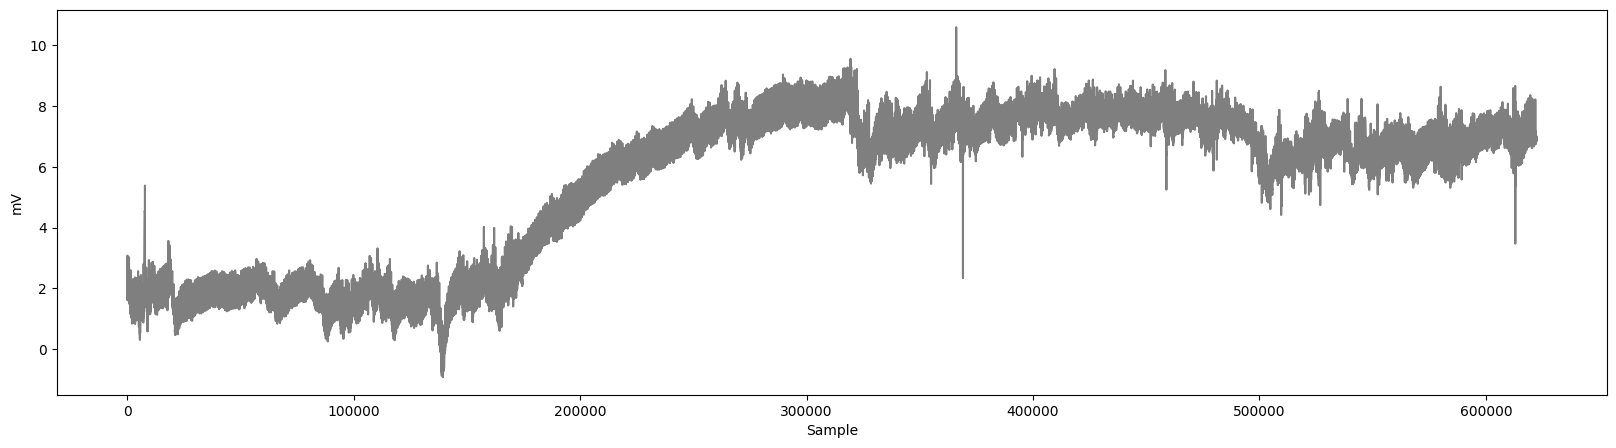

In [11]:
# Check data quality
df_ecg['ecg_la_ra'].iloc[0:].plot(figsize=(20, 5), color='C7')
plt.xlabel('Sample')
plt.ylabel('mV')

Text(0, 0.5, 'uS')

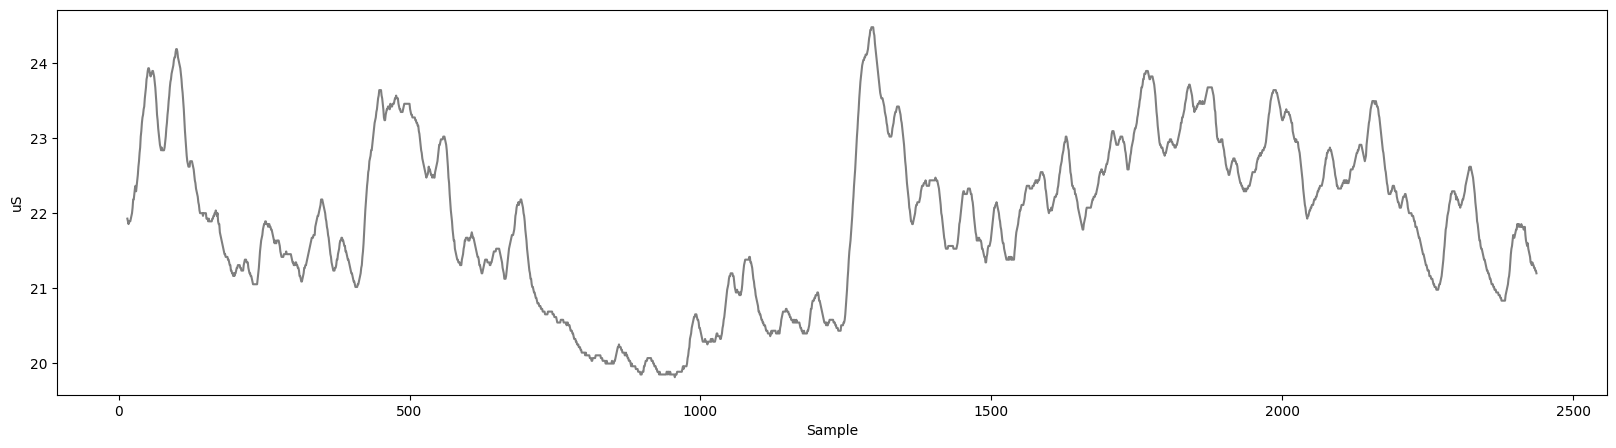

In [12]:
# Check data quality
df_eda['gsr_skin_conductance'].iloc[15:].plot(figsize=(20, 5), color='C7')
plt.xlabel('Sample')
plt.ylabel('uS')

In [13]:
# Re-sample to reduce sampling frequency
# The NN session had higher sampling frequency than the other sessions, so we need to downsample it
if session == 'NN':
    df_eda_resampled = df_eda[::16].reset_index(drop=True)
    df_eda = df_eda_resampled

In [14]:
# Save preprocessed data
df_eda = df_eda[['timestamp', 'gsr_skin_conductance', 'acc_x', 'acc_y', 'acc_z', 'temperature']]
df_eda.to_csv(output_dir + output_filename_eda, index=False)

## **Smoothen the signals**

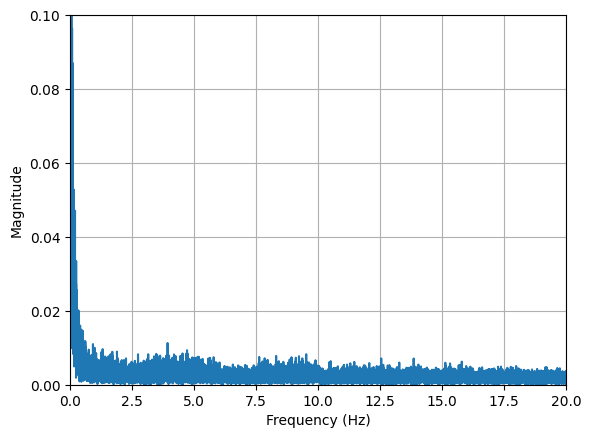

In [15]:
# Check frequency bands
N = len(df_ecg['ecg_la_ra'])
T = 1.0 / fs_ecg
# sample spacing
yf = fft(df_ecg['ecg_la_ra'])
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim([0, 20])
plt.ylim([0, 0.1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

Text(0, 0.5, 'mV')

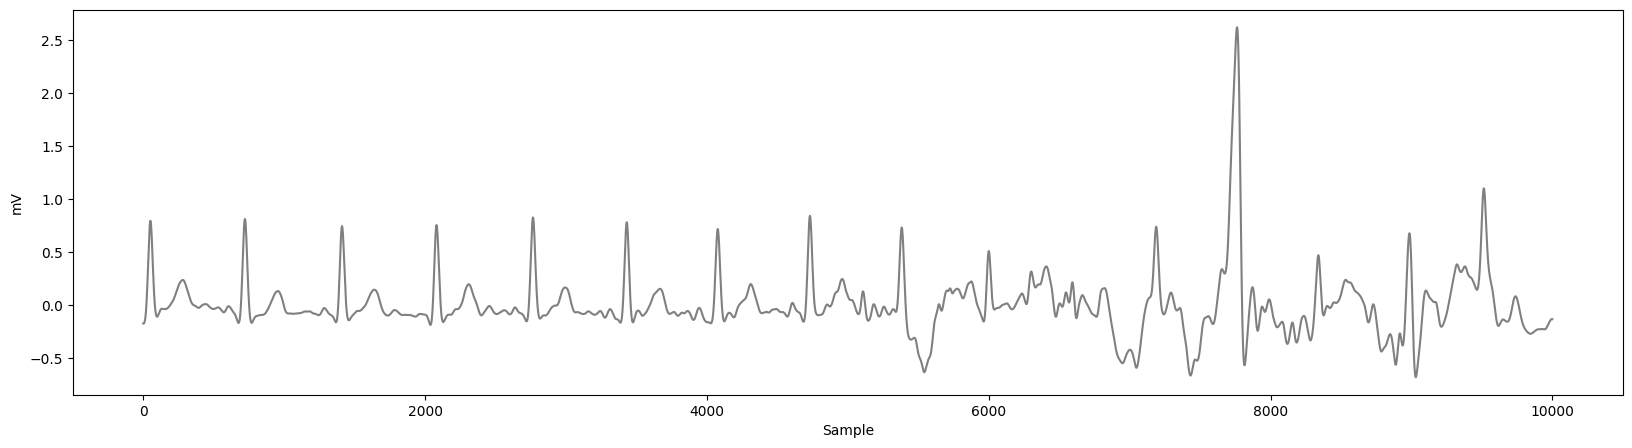

In [16]:
# Filter the ECG signal
Filter = ECG.Filters(fs=fs_ecg)
df_ecg['ecg_filtered'] = Filter.filter_signal(df_ecg['ecg_la_ra'], lowcut=1, highcut=10)
df_ecg['ecg_filtered'].iloc[0:10000].plot(figsize=(20, 5), color='gray')    # Set the range to plot
plt.xlabel('Sample')
plt.ylabel('mV')

In [17]:
# Detect R-peaks in case we need it later
# We did not use this in this study because we used the manually edited peaks with MindWare
BeatDetector = ECG.BeatDetectors(fs=fs_ecg, preprocessed=True)
ecg_beats = BeatDetector.manikandan(signal=df_ecg['ecg_filtered'], adaptive_threshold=True)
df_ecg['peak'] = 0
df_ecg.loc[ecg_beats, 'peak'] = 1

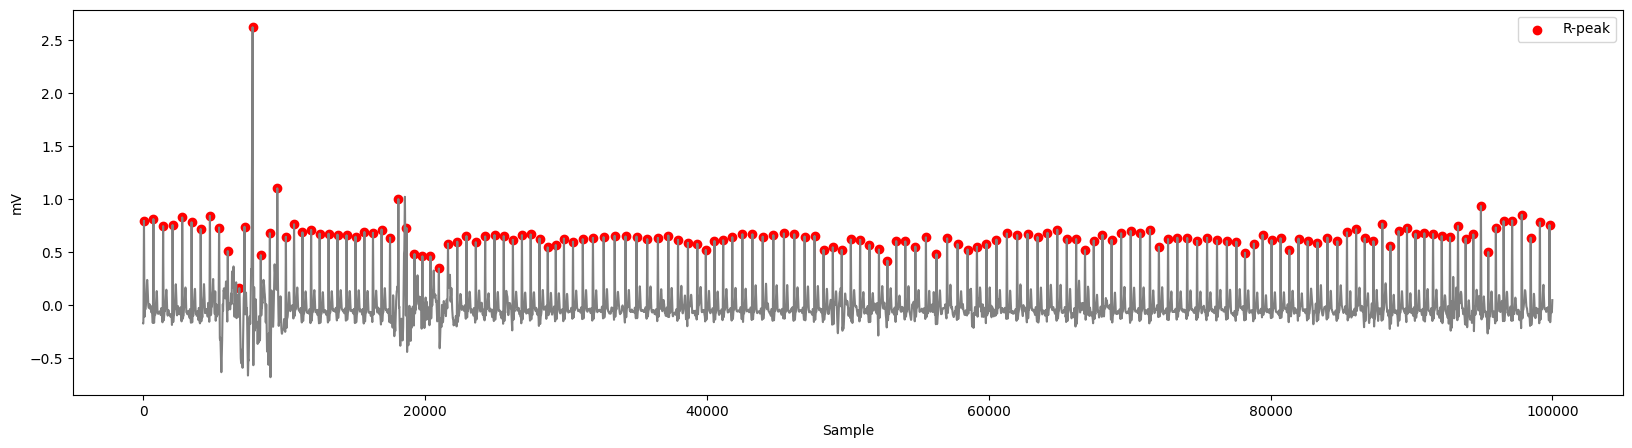

In [18]:
# Check the detected R-peaks
fig, ax = plt.subplots(figsize=(20, 5))
df_plot = df_ecg.iloc[0:100000]
ax.plot(df_plot['ecg_filtered'], color='gray')
ax.scatter(df_plot[df_plot['peak'] == 1].index, df_plot[df_plot['peak'] == 1]['ecg_filtered'], color='red', label='R-peak')
plt.xlabel('Sample')
plt.ylabel('mV')
plt.legend()

In [19]:
df_ecg = df_ecg[['timestamp', 'ecg_filtered', 'peak', 'acc_x', 'acc_y', 'acc_z', 'temperature']]
df_ecg.to_csv(output_dir + output_filename_ecg, index=False)